In [9]:
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt


#load dataset
series = read_csv('DailyDelhiClimateTest.csv',header=0, parse_dates=True,index_col=0,squeeze=True)

series.head()


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


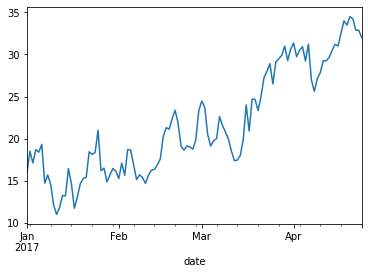

In [10]:
#line plot
series['meantemp'].plot()

In [11]:
series=series.drop(['humidity','wind_speed','meanpressure'], axis=1)

# Persistence Model

 A good baseline forecast for a time series with a linear increasing trend is a persistence forecast.


In [12]:
#prepare data
X=series.values
train_size = int(len(X)*0.6)
train, test = X[0:train_size], X[train_size:]
#walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    #predict
    yhat = history[-1]
    predictions.append(yhat)
    #observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

>Predicted=20.786, Expected=19.938
>Predicted=19.938, Expected=18.533
>Predicted=18.533, Expected=17.375
>Predicted=17.375, Expected=17.444
>Predicted=17.444, Expected=18.000
>Predicted=18.000, Expected=19.875
>Predicted=19.875, Expected=24.000
>Predicted=24.000, Expected=20.900
>Predicted=20.900, Expected=24.692
>Predicted=24.692, Expected=24.667
>Predicted=24.667, Expected=23.333
>Predicted=23.333, Expected=25.000
>Predicted=25.000, Expected=27.250
>Predicted=27.250, Expected=28.000
>Predicted=28.000, Expected=28.917
>Predicted=28.917, Expected=26.500
>Predicted=26.500, Expected=29.100
>Predicted=29.100, Expected=29.500
>Predicted=29.500, Expected=29.889
>Predicted=29.889, Expected=31.000
>Predicted=31.000, Expected=29.286
>Predicted=29.286, Expected=30.625
>Predicted=30.625, Expected=31.375
>Predicted=31.375, Expected=29.750
>Predicted=29.750, Expected=30.500
>Predicted=30.500, Expected=30.933
>Predicted=30.933, Expected=29.231
>Predicted=29.231, Expected=31.222
>Predicted=31.222, E

In [13]:
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 1.641


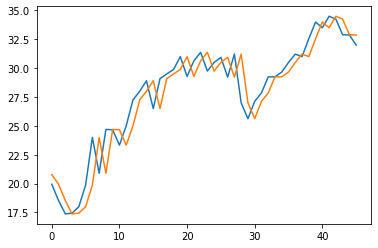

In [14]:
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions)
plt.show()

# LSTM Data Preparation

Before we can fit an LSTM model to the dataset, we must transform the data.

This section is broken down into two steps:

1. Transform the time series into a supervised learning problem

2. Transform the time series data so that it is stationary.




### Transform Time Series to Supervised Learning

The LSTM model in Keras assumes that your data is divided into input (X) and output (y) components.

For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.




In [15]:
import pandas as pd
from pandas import concat

In [16]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
 # put it all together
 agg = concat(cols, axis=1)
 # drop rows with NaN values
 agg.dropna(inplace=True)
 return agg.values

### Chech Stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(series)

1. ADF :  -1.096474275875619
2. P-Value :  0.7164758731775932
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 113
5. Critical Values :
	 1% :  -3.489589552580676
	 5% :  -2.887477210140433
	 10% :  -2.580604145195395


the Dickey Fuller Test shows that p-value>0.05, which means our time series don't contain any trend or seasonality. So, our time series is **not stationary** .

In [27]:
from pandas import Series


#Transform Time Series to Stationary by differencing
# create a differenced series
def difference(data, order):
 return [data[i] - data[i - order] for i in range(order, len(data))]



# LSTM Model Development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

- **Samples**: These are independent observations from the domain, typically rows of data.
- **Time steps**: These are separate time steps of a given variable for a given observation.
- **Features**: These are separate measures observed at the time of observation.




---



- The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.

- The batch size is often much smaller than the total number of samples. It, along with the number of epochs, defines how quickly the network learns the data (how often the weights are updated).

- The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.


---

We will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, and the efficient ADAM optimization algorithm.


---

**What's a batch size?**
The batch size defines the number of samples that will be propagated through the network.



The batch size defines the number of samples that will be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network.

Advantages of using a batch size < number of all samples:

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.
- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

In the neural network terminology:

- one **epoch** = one forward pass and one backward pass of all the training examples

- **batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.


In [20]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
 return sqrt(mean_squared_error(actual, predicted))

The hyperparameters for the LSTM model will be the same five as the MLP; they are:

- **n_input**: The number of prior inputs to use as input for the model (e.g. 10 days).
- **n_nodes**: The number of nodes to use in the hidden layer (e.g. 50).
- **n_epochs**: The number of training epochs (e.g. 1000).
- **n_batch**: The number of samples to include in each mini-batch (e.g. 32).
- **n_diff**: The difference order (e.g. 0 or 12).

In [21]:
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# fit a model
def model_fit(train, config):
 # unpack config
 n_input, n_nodes, n_epochs, n_batch, n_diff = config
 # prepare data
 if n_diff > 0:
  train = difference(train, n_diff)
 # transform series into supervised format
 data = series_to_supervised(train, n_in=n_input)
 # separate inputs and outputs
 train_x, train_y = data[:, :-1], data[:, -1]
 # reshape input data into [samples, timesteps, features]
 n_features = 1
 train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
 # define model
 model = Sequential()
 model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
 model.add(Dense(n_nodes, activation='relu'))
 model.add(Dense(1))
 model.compile(loss='mse', optimizer='adam')
 # fit model
 model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
 return model
 

# LSTM Forcast

Once the LSTM model is fit to the training data, it can be used to make forecasts.






In [22]:
# forecast with the fit model
def model_predict(model, history, config):
 # unpack config
 n_input, _, _, _, n_diff = config
 # prepare data
 correction = 0.0
 if n_diff > 0:
  correction = history[-n_diff]
  history = difference(history, n_diff)
 # reshape sample into [samples, timesteps, features]
 x_input = array(history[-n_input:]).reshape((1, n_input, 1))
 # forecast
 yhat = model.predict(x_input, verbose=0)
 return correction + yhat[0]

In [23]:
# walk-forward validation for univariate data
def walk_forward_validation(data, test_size, cfg):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, test_size)
 # fit model
 model = model_fit(train, cfg)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
  # fit model and make forecast for history
  yhat = model_predict(model, history, cfg)
  # store forecast in list of predictions
  predictions.append(yhat)
  # add actual observation to history for the next loop
  history.append(test[i])
 # estimate prediction error
 error = measure_rmse(test, predictions)
 print(' > %.3f' % error)
 return error

In [24]:
def evaluate_models(dataset, n_input, n_nodes, n_epochs, n_batch, n_diff):
    

    best_score, best_cfg = float("inf"), None
    for i in n_input:
      for j in n_nodes:
        for k in n_epochs:
          for l in n_batch:
            for m in n_diff:
                cfg = [i, j, k, l, m]
                try:
                    rmse = walk_forward_validation(dataset, len(dataset)-int(len(dataset)*0.6),cfg)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, cfg
                    print('LSTM%s RMSE=%.3f' % (cfg,rmse))
                except:
                    continue
    print('Best LSTM%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
# define scope of configs
n_input = [i for i in range(10)]
n_nodes = [i for i in range(100)]
n_epochs = [50]
n_batch = [i for i in range(20)]
n_diff = [i for i in range(10)]

In [ ]:
import warnings
warnings.filterwarnings("ignore")
evaluate_models(series.values, n_input, n_nodes, n_epochs, n_batch, n_diff)


Streaming output truncated to the last 5000 lines.
 > 5.245
LSTM[1, 4, 50, 18, 0] RMSE=5.245
 > 1.621
LSTM[1, 4, 50, 18, 1] RMSE=1.621
 > 1.998
LSTM[1, 4, 50, 18, 2] RMSE=1.998
 > 1.953
LSTM[1, 4, 50, 18, 3] RMSE=1.953
 > 2.501
LSTM[1, 4, 50, 18, 4] RMSE=2.501
 > 2.245
LSTM[1, 4, 50, 18, 5] RMSE=2.245
 > 3.602
LSTM[1, 4, 50, 18, 6] RMSE=3.602
 > 3.896
LSTM[1, 4, 50, 18, 7] RMSE=3.896
 > 4.064
LSTM[1, 4, 50, 18, 8] RMSE=4.064
 > 4.512
LSTM[1, 4, 50, 18, 9] RMSE=4.512
 > 28.063
LSTM[1, 4, 50, 19, 0] RMSE=28.063
 > 1.635
LSTM[1, 4, 50, 19, 1] RMSE=1.635
 > 1.966
LSTM[1, 4, 50, 19, 2] RMSE=1.966
 > 2.359
LSTM[1, 4, 50, 19, 3] RMSE=2.359
 > 2.626
LSTM[1, 4, 50, 19, 4] RMSE=2.626
 > 2.448
LSTM[1, 4, 50, 19, 5] RMSE=2.448
 > 2.488
LSTM[1, 4, 50, 19, 6] RMSE=2.488
 > 2.894
LSTM[1, 4, 50, 19, 7] RMSE=2.894
 > 3.572
LSTM[1, 4, 50, 19, 8] RMSE=3.572
 > 2.722
LSTM[1, 4, 50, 19, 9] RMSE=2.722
 > 27.820
LSTM[1, 5, 50, 0, 0] RMSE=27.820
 > 1.630
LSTM[1, 5, 50, 0, 1] RMSE=1.630
 > 1.971
LSTM[1, 5, 50,

In [25]:
#walk-forward validation
cfg = [2,11,50,15,1]
predictions = list()
# split dataset
train, test = train_test_split(series.values, len(series.values)-int(len(series.values)*0.6))
# fit model
model = model_fit(train, cfg)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
  # fit model and make forecast for history
  yhat = model_predict(model, history, cfg)
  # store forecast in list of predictions
  predictions.append(yhat)
  # add actual observation to history for the next loop
  history.append(test[i])

Test RMSE: 1.283


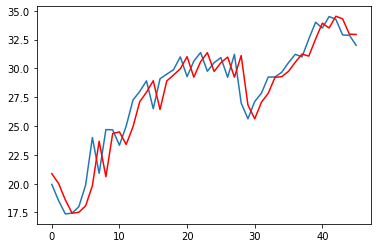

In [26]:
# report performance
rmse = sqrt(measure_rmse(test, predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test)
plt.plot(predictions, c='r')
plt.show()